# Redes neuronales

### LIBRERIAS

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



### Preprosesamiento de los datos

In [3]:
df = pd.read_csv('onc_train_full_with_target.csv')
# crea dos dataframes, uno con las caracteristicas y otro con la variable objetivo
X = df.drop('vive', axis=1)
y = df['vive']
# divide X en numericas y categoricas creando dos dataframes
X_num = X.select_dtypes(include=['int64', 'float64'])
X_cat = X.select_dtypes(include=['object', 'category'])
# de las variables categoricas y numericas dime que columnas tienen mas valores nulos y las que porcentaje de nulos tienen
nulos_cat = X_cat.isnull().sum().sort_values(ascending=False)
nulos_num = X_num.isnull().sum().sort_values(ascending=False)
porcentaje_nulos_cat = (nulos_cat / len(X_cat)) * 100
porcentaje_nulos_num = (nulos_num / len(X_num)) * 100
print("Variables categoricas con mas nulos:")
print(pd.concat([nulos_cat, porcentaje_nulos_cat], axis=1, keys=['Nulos', 'Porcentaje']).head())
print("\nVariables numericas con mas nulos:")
print(pd.concat([nulos_num, porcentaje_nulos_num], axis=1, keys=['Nulos', 'Porcentaje']).head())


Variables categoricas con mas nulos:
               Nulos  Porcentaje
mut_pi3k         430      1.0750
mut_egfr         424      1.0600
t_invasivo       423      1.0575
metastasis       423      1.0575
calidad_sueno    422      1.0550

Variables numericas con mas nulos:
                   Nulos  Porcentaje
eosinofilos          857      2.1425
fosforo              847      2.1175
urea                 840      2.1000
proteinas_totales    839      2.0975
glucosa              838      2.0950


#### En los nulos de categorias añadimos que hay missing y en las numericas ponemos las media

In [3]:
X_cat = X_cat.fillna("MISSING")
X_num = X_num.fillna(X_num.median())


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in X_cat.columns:
    enc = LabelEncoder()
    X_cat[col] = enc.fit_transform(X_cat[col].astype(str))
    label_encoders[col] = enc





In [5]:
from sklearn.model_selection import train_test_split

# Unir de nuevo numéricas + categóricas antes del split
X_full = pd.concat([X_num, X_cat], axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# → 60% train, 20% valid, 20% test
num_cols = X_num.columns
cat_cols = X_cat.columns

X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

X_valid_num = X_valid[num_cols]
X_valid_cat = X_valid[cat_cols]

X_test_num = X_test[num_cols]
X_test_cat = X_test[cat_cols]

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
scaler.fit(X_train_num.values.astype('float32'))   # SOLO train

X_train_num_scaled = scaler.transform(X_train_num.values.astype('float32'))
X_valid_num_scaled = scaler.transform(X_valid_num.values.astype('float32'))
X_test_num_scaled  = scaler.transform(X_test_num.values.astype('float32'))

X_train_cat_enc = X_train_cat.values.astype('float32')
X_valid_cat_enc = X_valid_cat.values.astype('float32')
X_test_cat_enc  = X_test_cat.values.astype('float32')

X_train_all = np.hstack([X_train_num_scaled, X_train_cat_enc])
X_valid_all = np.hstack([X_valid_num_scaled, X_valid_cat_enc])
X_test_all  = np.hstack([X_test_num_scaled,  X_test_cat_enc])



In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train.values).long()

X_valid_tensor = torch.from_numpy(X_valid_all).float()
y_valid_tensor = torch.from_numpy(y_valid.values).long()

X_test_tensor = torch.from_numpy(X_test_all).float()
y_test_tensor = torch.from_numpy(y_test.values).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)


Usando dispositivo: cuda


In [32]:
import torch.nn as nn
import torch.optim as optim

n_features = X_train_all.shape[1]

model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2)   # 2 clases: 0 = no vive, 1 = vive
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [21]:
def train_one_epoch():
    model.train()
    running_loss = 0.0

    for batchx, batchy in train_loader:
        batchx = batchx.to(device)
        batchy = batchy.to(device)

        optimizer.zero_grad()
        outputs = model(batchx)
        loss = criterion(outputs, batchy)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def eval_one_epoch(loader):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batchx, batchy in loader:
            batchx = batchx.to(device)
            batchy = batchy.to(device)

            outputs = model(batchx)
            loss = criterion(outputs, batchy)
            running_loss += loss.item()

    return running_loss / len(loader)


In [22]:
num_epochs = 50
history_train = []
history_valid = []

best_valid_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    valid_loss = eval_one_epoch(valid_loader)

    history_train.append(train_loss)
    history_valid.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"[Época {epoch:3d}] Nuevo mejor modelo guardado.")

    print(f"Época {epoch:3d} | train_loss = {train_loss:.4f} | valid_loss = {valid_loss:.4f}")


[Época   1] Nuevo mejor modelo guardado.
Época   1 | train_loss = 0.3818 | valid_loss = 0.3460
[Época   2] Nuevo mejor modelo guardado.
Época   2 | train_loss = 0.3399 | valid_loss = 0.3370
[Época   3] Nuevo mejor modelo guardado.
Época   3 | train_loss = 0.3352 | valid_loss = 0.3332
[Época   4] Nuevo mejor modelo guardado.
Época   4 | train_loss = 0.3327 | valid_loss = 0.3328
[Época   5] Nuevo mejor modelo guardado.
Época   5 | train_loss = 0.3322 | valid_loss = 0.3320
[Época   6] Nuevo mejor modelo guardado.
Época   6 | train_loss = 0.3310 | valid_loss = 0.3306
Época   7 | train_loss = 0.3296 | valid_loss = 0.3324
Época   8 | train_loss = 0.3289 | valid_loss = 0.3319
Época   9 | train_loss = 0.3284 | valid_loss = 0.3321
Época  10 | train_loss = 0.3273 | valid_loss = 0.3331
Época  11 | train_loss = 0.3245 | valid_loss = 0.3337
Época  12 | train_loss = 0.3236 | valid_loss = 0.3350
Época  13 | train_loss = 0.3216 | valid_loss = 0.3338
Época  14 | train_loss = 0.3202 | valid_loss = 0.335

## Primer modelo

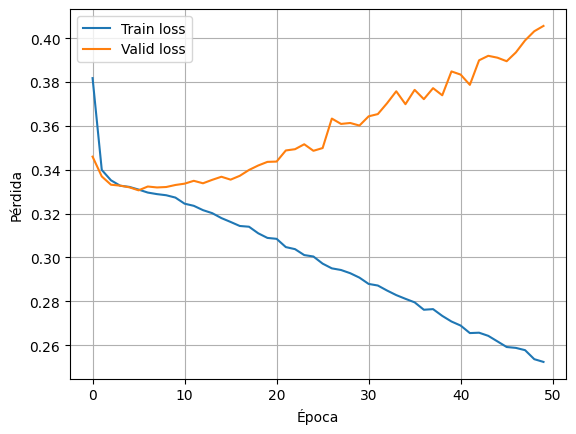

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_train, label="Train loss")
plt.plot(history_valid, label="Valid loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()


### Se observa un claro sobre ajuste, porlo que procedemos a buscar otro modelo con Early stoping

# EARLY STOPING

In [33]:
num_epochs = 200              # puedes poner un número grande, early stopping cortará antes
history_train = []
history_valid = []

best_valid_loss = float("inf")
patience = 10                 # nº de épocas sin mejora permitidas
no_improve_epochs = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    valid_loss = eval_one_epoch(valid_loader)

    history_train.append(train_loss)
    history_valid.append(valid_loss)

    # ¿Ha mejorado la valid_loss?
    if valid_loss < best_valid_loss - 1e-4:   # margen pequeñito para evitar ruido
        best_valid_loss = valid_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"[Época {epoch:3d}] Nuevo mejor modelo guardado. valid_loss = {valid_loss:.4f}")
    else:
        no_improve_epochs += 1
        print(f"[Época {epoch:3d}] Sin mejora en validación ({no_improve_epochs}/{patience})")

    print(f"           train_loss = {train_loss:.4f} | valid_loss = {valid_loss:.4f}")

    # ¿Se agotó la paciencia?
    if no_improve_epochs >= patience:
        print("\n⛔ Early stopping activado.")
        break


[Época   1] Nuevo mejor modelo guardado. valid_loss = 0.6916
           train_loss = 0.6989 | valid_loss = 0.6916
[Época   2] Nuevo mejor modelo guardado. valid_loss = 0.6781
           train_loss = 0.6848 | valid_loss = 0.6781
[Época   3] Nuevo mejor modelo guardado. valid_loss = 0.6628
           train_loss = 0.6704 | valid_loss = 0.6628
[Época   4] Nuevo mejor modelo guardado. valid_loss = 0.6451
           train_loss = 0.6536 | valid_loss = 0.6451
[Época   5] Nuevo mejor modelo guardado. valid_loss = 0.6259
           train_loss = 0.6347 | valid_loss = 0.6259
[Época   6] Nuevo mejor modelo guardado. valid_loss = 0.6057
           train_loss = 0.6146 | valid_loss = 0.6057
[Época   7] Nuevo mejor modelo guardado. valid_loss = 0.5846
           train_loss = 0.5936 | valid_loss = 0.5846
[Época   8] Nuevo mejor modelo guardado. valid_loss = 0.5630
           train_loss = 0.5718 | valid_loss = 0.5630
[Época   9] Nuevo mejor modelo guardado. valid_loss = 0.5413
           train_loss = 0.5

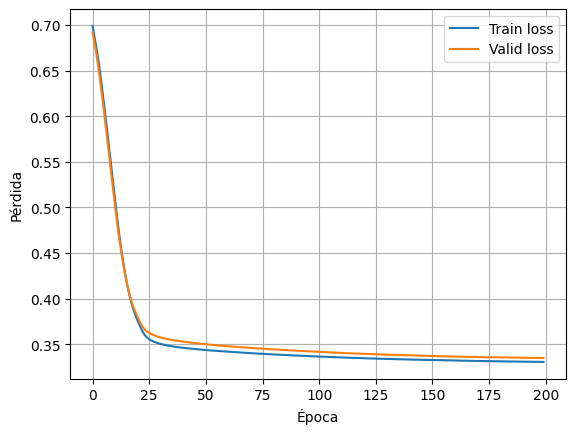

In [34]:
import matplotlib.pyplot as plt

plt.plot(history_train, label="Train loss")
plt.plot(history_valid, label="Valid loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()


## Train y Valid convergen muy bien porlo que esperamos buenos resultados

In [ ]:
#cargar el mejor modelo guardado
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
model.eval()


C:\Users\sevas\AppData\Local\Temp\ipykernel_20700\1178643536.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Sequential(
  (0): Linear(in_features=90, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
)

In [36]:
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        probs = torch.softmax(logits, dim=1)[:, 1]     # prob clase positiva
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [38]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns


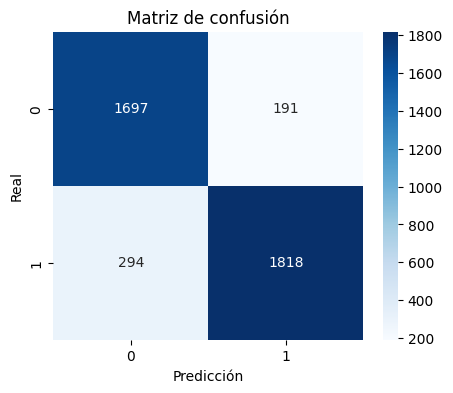

In [39]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()


In [40]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print()
print(classification_report(all_labels, all_preds, digits=4))


Accuracy: 0.87875

              precision    recall  f1-score   support

           0     0.8523    0.8988    0.8750      1888
           1     0.9049    0.8608    0.8823      2112

    accuracy                         0.8788      4000
   macro avg     0.8786    0.8798    0.8786      4000
weighted avg     0.8801    0.8788    0.8788      4000



In [41]:
auc = roc_auc_score(all_labels, all_probs)
print("ROC AUC =", auc)


ROC AUC = 0.9285918139284797


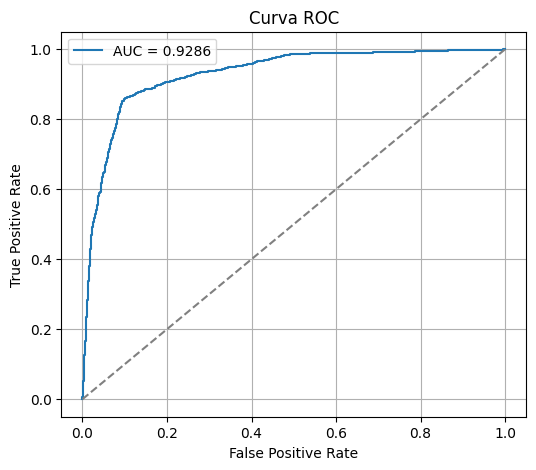

In [42]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()


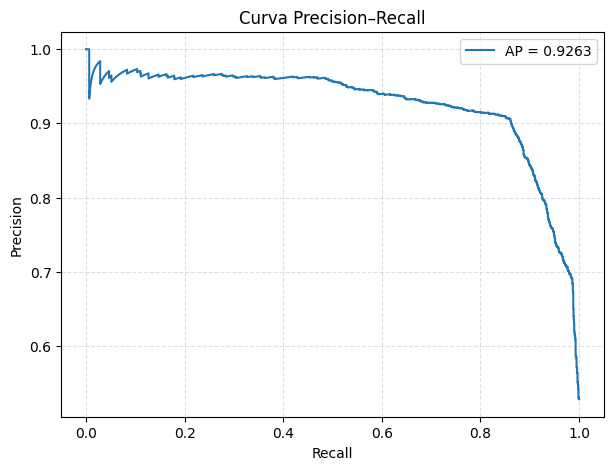

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculamos puntos de la curva
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

# Average precision (área bajo la curva PR)
ap = average_precision_score(all_labels, all_probs)

# Pintar curva
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()


# prueba limpio

In [49]:
limpio=pd.read_csv('onc_fresh_full_no_target.csv')

In [50]:
import numpy as np
import pandas as pd
import torch

# Dataset nuevo
limpio = pd.read_csv("onc_fresh_full_no_target.csv")

# Asegurarnos de que tiene las mismas columnas
num_cols = X_num.columns
cat_cols = X_cat.columns

df_new = limpio.copy()

# --- NUMÉRICAS ---
df_new_num = df_new[num_cols].copy()

# Usamos las mismas medianas que en el dataset original
num_medians = X_num.median()
df_new_num = df_new_num.fillna(num_medians)

# Escalamos con el scaler ya entrenado
new_num_scaled = scaler.transform(df_new_num.values.astype("float32"))

# --- CATEGÓRICAS ---
df_new_cat = df_new[cat_cols].copy()
df_new_cat = df_new_cat.fillna("MISSING")

for col in cat_cols:
    enc = label_encoders[col]

    # Asegurar que solo haya categorías conocidas; las desconocidas → "MISSING"
    known = set(enc.classes_)
    df_new_cat[col] = (
        df_new_cat[col]
        .astype(str)
        .where(df_new_cat[col].astype(str).isin(known), other="MISSING")
    )

    # Transformar a enteros
    df_new_cat[col] = enc.transform(df_new_cat[col].astype(str))

new_cat_encoded = df_new_cat.values.astype("float32")

# --- UNIR NUMÉRICAS + CATEGÓRICAS ---
X_new_all = np.hstack([new_num_scaled, new_cat_encoded]).astype("float32")

# A tensor en GPU
X_new_tensor = torch.from_numpy(X_new_all).to(device)


In [51]:
import torch.nn.functional as F

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    logits = model(X_new_tensor)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()  # prob de clase 1 (por ejemplo, "vive")
    preds = logits.argmax(dim=1).cpu().numpy()


C:\Users\sevas\AppData\Local\Temp\ipykernel_20700\3010309955.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locati

In [52]:
print("Número de pacientes nuevos:", len(probs))
print("Predichos como clase 1:", (preds == 1).sum())
print("Predichos como clase 0:", (preds == 0).sum())
print()
print("Probabilidad media (clase 1):", probs.mean())
print("Probabilidad mínima:", probs.min())
print("Probabilidad máxima:", probs.max())


Número de pacientes nuevos: 5000
Predichos como clase 1: 2520
Predichos como clase 0: 2480

Probabilidad media (clase 1): 0.52979285
Probabilidad mínima: 0.015275381
Probabilidad máxima: 0.98475605


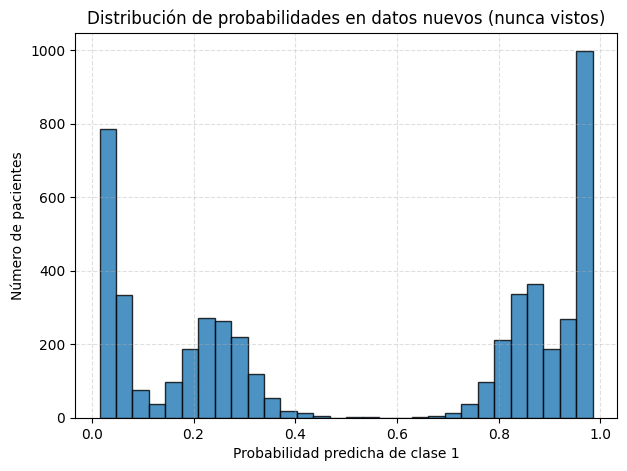

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(probs, bins=30, edgecolor="black", alpha=0.8)
plt.xlabel("Probabilidad predicha de clase 1")
plt.ylabel("Número de pacientes")
plt.title("Distribución de probabilidades en datos nuevos (nunca vistos)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


# el modelo da buenos resultados, dando una grafica bimodal, pero seguiremos mejorandolo

## CAMBIO DE IDEA CON LAS VARIABLES

#### Apartir de aqui los modelos se cargaran solo cn una linea de codigo para ahorrar espacio y limpieza, y se aplicara un tranformacion a los datos numericos que aparte de cambiar sus valores nulos por su mediana crearemos una columna para cada una de las variblaes numericas donde hayamos sustituido un nulo, donde asi el modelo sabra que aunque haya sustituido por la mediana sabra que es un valor inventado.

# 1

Usando dispositivo: cuda
Shapes -> Train: (32000, 90) Valid: (4000, 90) Test: (4000, 90)
Feature dims -> 136 features totales
[Época   1] Nuevo mejor modelo guardado. valid_loss = 0.6866
           train_loss = 0.6971 | valid_loss = 0.6866
[Época   2] Nuevo mejor modelo guardado. valid_loss = 0.6693
           train_loss = 0.6805 | valid_loss = 0.6693
[Época   3] Nuevo mejor modelo guardado. valid_loss = 0.6503
           train_loss = 0.6645 | valid_loss = 0.6503
[Época   4] Nuevo mejor modelo guardado. valid_loss = 0.6283
           train_loss = 0.6450 | valid_loss = 0.6283
[Época   5] Nuevo mejor modelo guardado. valid_loss = 0.6036
           train_loss = 0.6233 | valid_loss = 0.6036
[Época   6] Nuevo mejor modelo guardado. valid_loss = 0.5767
           train_loss = 0.6008 | valid_loss = 0.5767
[Época   7] Nuevo mejor modelo guardado. valid_loss = 0.5484
           train_loss = 0.5751 | valid_loss = 0.5484
[Época   8] Nuevo mejor modelo guardado. valid_loss = 0.5196
           trai

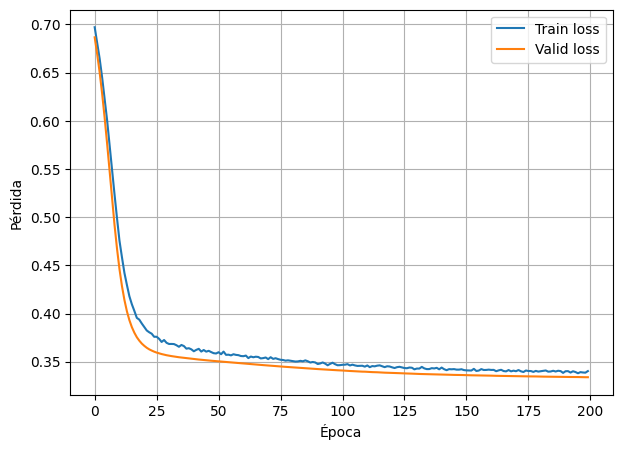

C:\Users\sevas\AppData\Local\Temp\ipykernel_20700\985990804.py:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locat

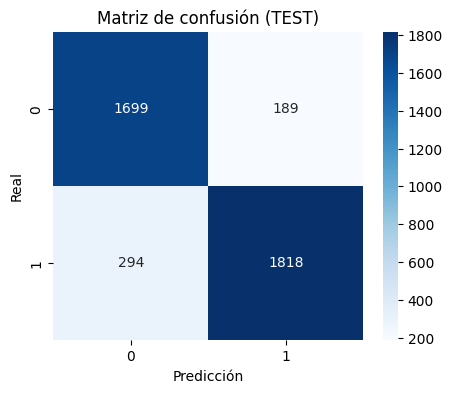

Accuracy: 0.87925

              precision    recall  f1-score   support

           0     0.8525    0.8999    0.8755      1888
           1     0.9058    0.8608    0.8827      2112

    accuracy                         0.8792      4000
   macro avg     0.8792    0.8803    0.8791      4000
weighted avg     0.8807    0.8792    0.8793      4000



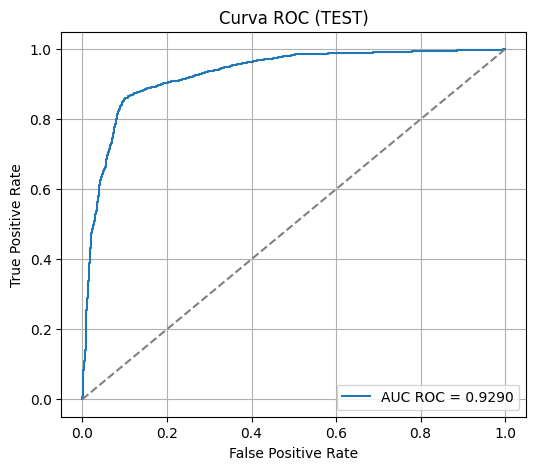

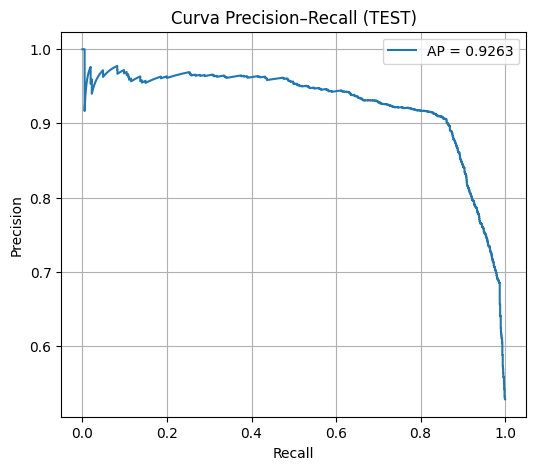

Nuevos pacientes: 5000
Predichos clase 1: 2517
Predichos clase 0: 2483
Probabilidad media clase 1: 0.52885646


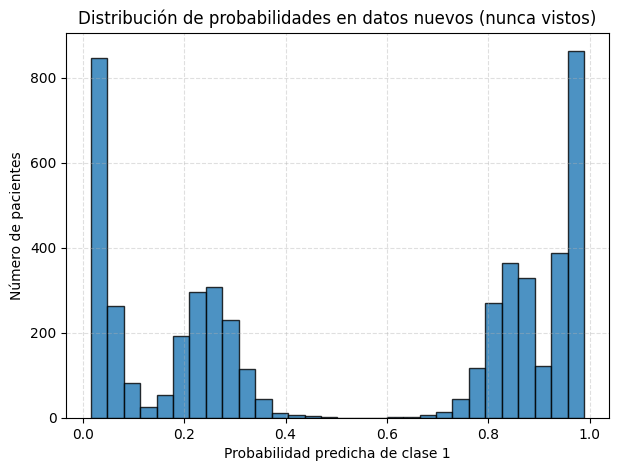

Archivo 'onc_fresh_con_predicciones.csv' guardado.


In [56]:
# ============================================================
# 0. IMPORTS Y DISPOSITIVO
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, accuracy_score,
    precision_recall_curve, average_precision_score
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# ============================================================
# 1. SEPARAR TRAIN / VALID / TEST A PARTIR DE X_num, X_cat, y
# ============================================================

# Unimos numéricas + categóricas
X_full = pd.concat([X_num, X_cat], axis=1)

num_cols = X_num.columns.tolist()
cat_cols = X_cat.columns.tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes ->",
      "Train:", X_train.shape,
      "Valid:", X_valid.shape,
      "Test:",  X_test.shape)

# ============================================================
# 2. IMPUTACIÓN DE NUMÉRICAS + COLUMNAS _missing
#    (SE AJUSTA SOLO CON TRAIN)
# ============================================================

# --- NUMÉRICAS TRAIN ---
X_train_num = X_train[num_cols].copy()
X_valid_num = X_valid[num_cols].copy()
X_test_num  = X_test[num_cols].copy()

# Medianas calculadas SOLO en train
num_medians = X_train_num.median()

# Añadimos columnas *_missing + rellenamos con la mediana
for col in num_cols:
    # columnas missing
    X_train_num[col + "_missing"] = X_train_num[col].isna().astype(int)
    X_valid_num[col + "_missing"] = X_valid_num[col].isna().astype(int)
    X_test_num[col  + "_missing"] = X_test_num[col].isna().astype(int)

    # rellenar NaNs con mediana de TRAIN
    X_train_num[col] = X_train_num[col].fillna(num_medians[col])
    X_valid_num[col] = X_valid_num[col].fillna(num_medians[col])
    X_test_num[col]  = X_test_num[col].fillna(num_medians[col])

# Nueva lista de columnas numéricas (incluye *_missing)
num_cols_extended = X_train_num.columns.tolist()

# ============================================================
# 3. CATEGÓRICAS: IMPUTACIÓN "MISSING" + LABEL ENCODER
#    (SE AJUSTA SOLO CON TRAIN)
# ============================================================

X_train_cat = X_train[cat_cols].copy()
X_valid_cat = X_valid[cat_cols].copy()
X_test_cat  = X_test[cat_cols].copy()

X_train_cat = X_train_cat.fillna("MISSING")
X_valid_cat = X_valid_cat.fillna("MISSING")
X_test_cat  = X_test_cat.fillna("MISSING")

label_encoders = {}

for col in cat_cols:
    enc = LabelEncoder()
    X_train_cat[col] = enc.fit_transform(X_train_cat[col].astype(str))

    # Para valid/test, sustituimos categorías desconocidas por "MISSING"
    known = set(enc.classes_)
    X_valid_cat[col] = (
        X_valid_cat[col]
        .astype(str)
        .where(X_valid_cat[col].astype(str).isin(known), other="MISSING")
    )
    X_test_cat[col] = (
        X_test_cat[col]
        .astype(str)
        .where(X_test_cat[col].astype(str).isin(known), other="MISSING")
    )

    X_valid_cat[col] = enc.transform(X_valid_cat[col].astype(str))
    X_test_cat[col]  = enc.transform(X_test_cat[col].astype(str))

    label_encoders[col] = enc

# ============================================================
# 4. ESCALADO DE NUMÉRICAS (SOLO LAS NO *_missing)
# ============================================================

# columnas que son valores numéricos reales (sin los *_missing)
original_num_cols = num_cols  # las iniciales
missing_flag_cols = [c for c in num_cols_extended if c.endswith("_missing")]

scaler = StandardScaler()
scaler.fit(X_train_num[original_num_cols].values.astype("float32"))

X_train_num_scaled_values = scaler.transform(X_train_num[original_num_cols].values.astype("float32"))
X_valid_num_scaled_values = scaler.transform(X_valid_num[original_num_cols].values.astype("float32"))
X_test_num_scaled_values  = scaler.transform(X_test_num[original_num_cols].values.astype("float32"))

# reconstruimos DataFrames numéricos escalados + flags
X_train_num_scaled = pd.DataFrame(
    X_train_num_scaled_values,
    columns=original_num_cols,
    index=X_train_num.index
)
X_valid_num_scaled = pd.DataFrame(
    X_valid_num_scaled_values,
    columns=original_num_cols,
    index=X_valid_num.index
)
X_test_num_scaled = pd.DataFrame(
    X_test_num_scaled_values,
    columns=original_num_cols,
    index=X_test_num.index
)

# añadimos flags *_missing (no se escalan)
for col in missing_flag_cols:
    X_train_num_scaled[col] = X_train_num[col].values
    X_valid_num_scaled[col] = X_valid_num[col].values
    X_test_num_scaled[col]  = X_test_num[col].values

# ============================================================
# 5. CONSTRUIR MATRICES FINALES DE FEATURES
# ============================================================

X_train_all = np.hstack([
    X_train_num_scaled.values.astype("float32"),
    X_train_cat.values.astype("float32")
])

X_valid_all = np.hstack([
    X_valid_num_scaled.values.astype("float32"),
    X_valid_cat.values.astype("float32")
])

X_test_all = np.hstack([
    X_test_num_scaled.values.astype("float32"),
    X_test_cat.values.astype("float32")
])

print("Feature dims ->", X_train_all.shape[1], "features totales")

# ============================================================
# 6. TENSORES Y DATALOADERS
# ============================================================

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(np.array(y_train)).long()

X_valid_tensor = torch.from_numpy(X_valid_all).float()
y_valid_tensor = torch.from_numpy(np.array(y_valid)).long()

X_test_tensor = torch.from_numpy(X_test_all).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

# ============================================================
# 7. DEFINIR MODELO (CON DROPOUT) + OPTIMIZADOR
# ============================================================

n_features = X_train_all.shape[1]

model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 2)   # 2 clases
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# ============================================================
# 8. FUNCIONES DE TRAIN / EVAL
# ============================================================

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for batchx, batchy in train_loader:
        batchx = batchx.to(device)
        batchy = batchy.to(device)

        optimizer.zero_grad()
        outputs = model(batchx)
        loss = criterion(outputs, batchy)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


def eval_one_epoch(loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batchx, batchy in loader:
            batchx = batchx.to(device)
            batchy = batchy.to(device)

            outputs = model(batchx)
            loss = criterion(outputs, batchy)
            running_loss += loss.item()
    return running_loss / len(loader)

# ============================================================
# 9. ENTRENAMIENTO CON EARLY STOPPING
# ============================================================

num_epochs = 200
history_train = []
history_valid = []

best_valid_loss = float("inf")
patience = 10
no_improve_epochs = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    valid_loss = eval_one_epoch(valid_loader)

    history_train.append(train_loss)
    history_valid.append(valid_loss)

    if valid_loss < best_valid_loss - 1e-4:
        best_valid_loss = valid_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"[Época {epoch:3d}] Nuevo mejor modelo guardado. valid_loss = {valid_loss:.4f}")
    else:
        no_improve_epochs += 1
        print(f"[Época {epoch:3d}] Sin mejora ({no_improve_epochs}/{patience})")

    print(f"           train_loss = {train_loss:.4f} | valid_loss = {valid_loss:.4f}")

    if no_improve_epochs >= patience:
        print("\n⛔ Early stopping activado.")
        break

# Curvas de pérdida
plt.figure(figsize=(7,5))
plt.plot(history_train, label="Train loss")
plt.plot(history_valid, label="Valid loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 10. EVALUACIÓN EN TEST (MATRIZ, ROC, PR)
# ============================================================

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión (TEST)")
plt.show()

# --- Métricas ---
print("Accuracy:", accuracy_score(all_labels, all_preds))
print()
print(classification_report(all_labels, all_preds, digits=4))

# --- ROC y AUC ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_roc = roc_auc_score(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (TEST)")
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall ---
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap = average_precision_score(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall (TEST)")
plt.grid(True)
plt.legend()
plt.show()

# ============================================================
# 11. PREDICCIONES EN DATOS NUEVOS (limpio) + HISTOGRAMA
# ============================================================

limpio = pd.read_csv("onc_fresh_full_no_target.csv")
df_new = limpio.copy()

# --- NUMÉRICAS ---
df_new_num = df_new[num_cols].copy()

for col in num_cols:
    df_new_num[col + "_missing"] = df_new_num[col].isna().astype(int)
    df_new_num[col] = df_new_num[col].fillna(num_medians[col])

# Escalar columnas numéricas originales
new_num_scaled_vals = scaler.transform(df_new_num[original_num_cols].values.astype("float32"))
df_new_num_scaled = pd.DataFrame(
    new_num_scaled_vals,
    columns=original_num_cols,
    index=df_new_num.index
)

# añadir flags *_missing
for col in missing_flag_cols:
    df_new_num_scaled[col] = df_new_num[col].values

# --- CATEGÓRICAS ---
df_new_cat = df_new[cat_cols].copy().fillna("MISSING")

for col in cat_cols:
    enc = label_encoders[col]
    known = set(enc.classes_)
    df_new_cat[col] = (
        df_new_cat[col]
        .astype(str)
        .where(df_new_cat[col].astype(str).isin(known), other="MISSING")
    )
    df_new_cat[col] = enc.transform(df_new_cat[col].astype(str))

# --- UNIR NUM + CAT ---
X_new_all = np.hstack([
    df_new_num_scaled.values.astype("float32"),
    df_new_cat.values.astype("float32")
])

X_new_tensor = torch.from_numpy(X_new_all).float().to(device)

model.eval()
with torch.no_grad():
    logits_new = model(X_new_tensor)
    probs_new = F.softmax(logits_new, dim=1)[:, 1].cpu().numpy()
    preds_new = logits_new.argmax(dim=1).cpu().numpy()

print("Nuevos pacientes:", len(probs_new))
print("Predichos clase 1:", (preds_new == 1).sum())
print("Predichos clase 0:", (preds_new == 0).sum())
print("Probabilidad media clase 1:", probs_new.mean())

# Histograma de probabilidades
plt.figure(figsize=(7,5))
plt.hist(probs_new, bins=30, edgecolor="black", alpha=0.8)
plt.xlabel("Probabilidad predicha de clase 1")
plt.ylabel("Número de pacientes")
plt.title("Distribución de probabilidades en datos nuevos (nunca vistos)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Guardar CSV con predicciones (opcional)
salida = limpio.copy()
salida["prob_clase_1"] = probs_new
salida["pred_clase"] = preds_new
salida.to_csv("onc_fresh_con_predicciones.csv", index=False)
print("Archivo 'onc_fresh_con_predicciones.csv' guardado.")


# 2

Usando dispositivo: cuda
Shapes -> Train: (32000, 90) Valid: (4000, 90) Test: (4000, 90)
Feature dims -> 136 features totales
[Época   1] Nuevo mejor modelo guardado. valid_loss = 0.7008
           train_loss = 0.7042 | valid_loss = 0.7008
[Época   2] Nuevo mejor modelo guardado. valid_loss = 0.7002
           train_loss = 0.7031 | valid_loss = 0.7002
[Época   3] Nuevo mejor modelo guardado. valid_loss = 0.6995
           train_loss = 0.7025 | valid_loss = 0.6995
[Época   4] Nuevo mejor modelo guardado. valid_loss = 0.6989
           train_loss = 0.7017 | valid_loss = 0.6989
[Época   5] Nuevo mejor modelo guardado. valid_loss = 0.6983
           train_loss = 0.7019 | valid_loss = 0.6983
[Época   6] Nuevo mejor modelo guardado. valid_loss = 0.6977
           train_loss = 0.7008 | valid_loss = 0.6977
[Época   7] Nuevo mejor modelo guardado. valid_loss = 0.6971
           train_loss = 0.6997 | valid_loss = 0.6971
[Época   8] Nuevo mejor modelo guardado. valid_loss = 0.6966
           trai

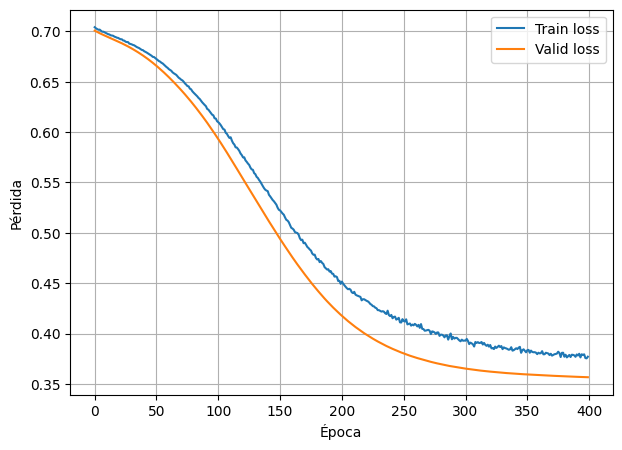

C:\Users\sevas\AppData\Local\Temp\ipykernel_11064\2189357846.py:301: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_loca

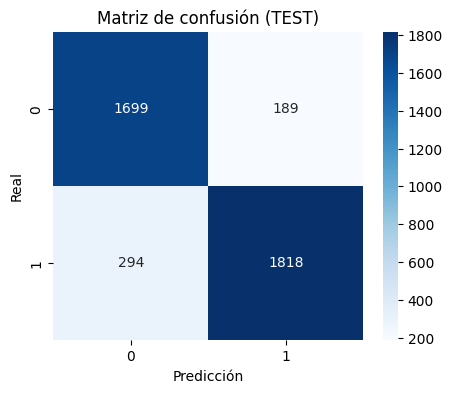

Accuracy: 0.87925

              precision    recall  f1-score   support

           0     0.8525    0.8999    0.8755      1888
           1     0.9058    0.8608    0.8827      2112

    accuracy                         0.8792      4000
   macro avg     0.8792    0.8803    0.8791      4000
weighted avg     0.8807    0.8792    0.8793      4000



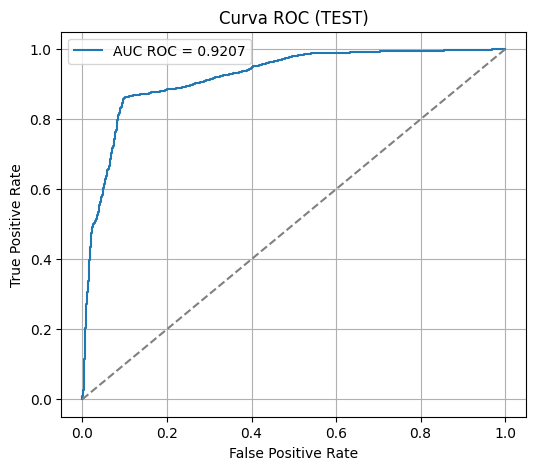

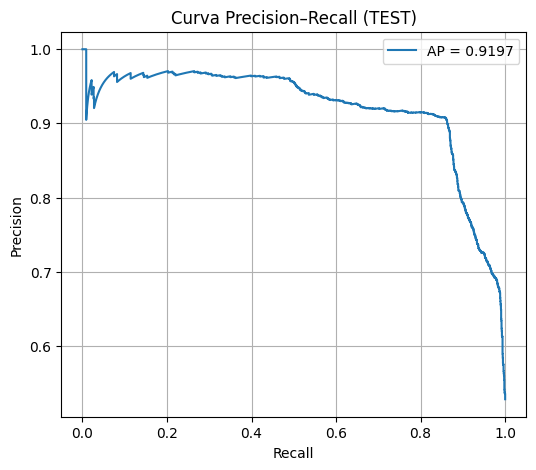

Nuevos pacientes: 5000
Predichos clase 1: 2517
Predichos clase 0: 2483
Probabilidad media clase 1: 0.52336943


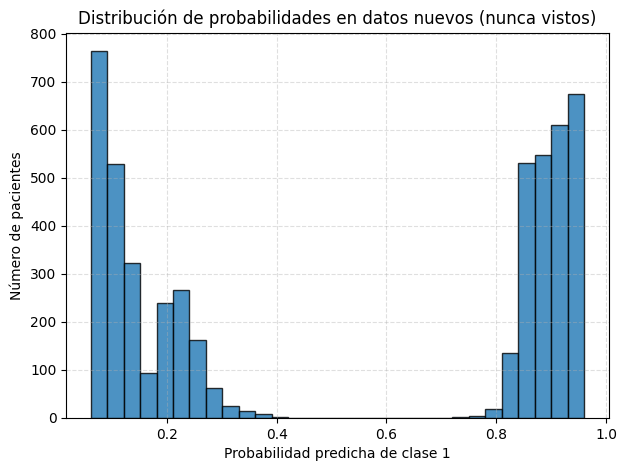

Archivo 'onc_fresh_con_predicciones.csv' guardado.


In [5]:
# ============================================================
# 0. IMPORTS Y DISPOSITIVO
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, accuracy_score,
    precision_recall_curve, average_precision_score
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# ============================================================
# 1. SEPARAR TRAIN / VALID / TEST A PARTIR DE X_num, X_cat, y
# ============================================================

# Unimos numéricas + categóricas
X_full = pd.concat([X_num, X_cat], axis=1)

num_cols = X_num.columns.tolist()
cat_cols = X_cat.columns.tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes ->",
      "Train:", X_train.shape,
      "Valid:", X_valid.shape,
      "Test:",  X_test.shape)

# ============================================================
# 2. IMPUTACIÓN DE NUMÉRICAS + COLUMNAS _missing
#    (SE AJUSTA SOLO CON TRAIN)
# ============================================================

# --- NUMÉRICAS TRAIN ---
X_train_num = X_train[num_cols].copy()
X_valid_num = X_valid[num_cols].copy()
X_test_num  = X_test[num_cols].copy()

# Medianas calculadas SOLO en train
num_medians = X_train_num.median()

# Añadimos columnas *_missing + rellenamos con la mediana
for col in num_cols:
    # columnas missing
    X_train_num[col + "_missing"] = X_train_num[col].isna().astype(int)
    X_valid_num[col + "_missing"] = X_valid_num[col].isna().astype(int)
    X_test_num[col  + "_missing"] = X_test_num[col].isna().astype(int)

    # rellenar NaNs con mediana de TRAIN
    X_train_num[col] = X_train_num[col].fillna(num_medians[col])
    X_valid_num[col] = X_valid_num[col].fillna(num_medians[col])
    X_test_num[col]  = X_test_num[col].fillna(num_medians[col])

# Nueva lista de columnas numéricas (incluye *_missing)
num_cols_extended = X_train_num.columns.tolist()

# ============================================================
# 3. CATEGÓRICAS: IMPUTACIÓN "MISSING" + LABEL ENCODER
#    (SE AJUSTA SOLO CON TRAIN)
# ============================================================

X_train_cat = X_train[cat_cols].copy()
X_valid_cat = X_valid[cat_cols].copy()
X_test_cat  = X_test[cat_cols].copy()

X_train_cat = X_train_cat.fillna("MISSING")
X_valid_cat = X_valid_cat.fillna("MISSING")
X_test_cat  = X_test_cat.fillna("MISSING")

label_encoders = {}

for col in cat_cols:
    enc = LabelEncoder()
    X_train_cat[col] = enc.fit_transform(X_train_cat[col].astype(str))

    # Para valid/test, sustituimos categorías desconocidas por "MISSING"
    known = set(enc.classes_)
    X_valid_cat[col] = (
        X_valid_cat[col]
        .astype(str)
        .where(X_valid_cat[col].astype(str).isin(known), other="MISSING")
    )
    X_test_cat[col] = (
        X_test_cat[col]
        .astype(str)
        .where(X_test_cat[col].astype(str).isin(known), other="MISSING")
    )

    X_valid_cat[col] = enc.transform(X_valid_cat[col].astype(str))
    X_test_cat[col]  = enc.transform(X_test_cat[col].astype(str))

    label_encoders[col] = enc

# ============================================================
# 4. ESCALADO DE NUMÉRICAS (SOLO LAS NO *_missing)
# ============================================================

# columnas que son valores numéricos reales (sin los *_missing)
original_num_cols = num_cols  # las iniciales
missing_flag_cols = [c for c in num_cols_extended if c.endswith("_missing")]

scaler = StandardScaler()
scaler.fit(X_train_num[original_num_cols].values.astype("float32"))

X_train_num_scaled_values = scaler.transform(X_train_num[original_num_cols].values.astype("float32"))
X_valid_num_scaled_values = scaler.transform(X_valid_num[original_num_cols].values.astype("float32"))
X_test_num_scaled_values  = scaler.transform(X_test_num[original_num_cols].values.astype("float32"))

# reconstruimos DataFrames numéricos escalados + flags
X_train_num_scaled = pd.DataFrame(
    X_train_num_scaled_values,
    columns=original_num_cols,
    index=X_train_num.index
)
X_valid_num_scaled = pd.DataFrame(
    X_valid_num_scaled_values,
    columns=original_num_cols,
    index=X_valid_num.index
)
X_test_num_scaled = pd.DataFrame(
    X_test_num_scaled_values,
    columns=original_num_cols,
    index=X_test_num.index
)

# añadimos flags *_missing (no se escalan)
for col in missing_flag_cols:
    X_train_num_scaled[col] = X_train_num[col].values
    X_valid_num_scaled[col] = X_valid_num[col].values
    X_test_num_scaled[col]  = X_test_num[col].values

# ============================================================
# 5. CONSTRUIR MATRICES FINALES DE FEATURES
# ============================================================

X_train_all = np.hstack([
    X_train_num_scaled.values.astype("float32"),
    X_train_cat.values.astype("float32")
])

X_valid_all = np.hstack([
    X_valid_num_scaled.values.astype("float32"),
    X_valid_cat.values.astype("float32")
])

X_test_all = np.hstack([
    X_test_num_scaled.values.astype("float32"),
    X_test_cat.values.astype("float32")
])

print("Feature dims ->", X_train_all.shape[1], "features totales")

# ============================================================
# 6. TENSORES Y DATALOADERS
# ============================================================

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(np.array(y_train)).long()

X_valid_tensor = torch.from_numpy(X_valid_all).float()
y_valid_tensor = torch.from_numpy(np.array(y_valid)).long()

X_test_tensor = torch.from_numpy(X_test_all).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

# ============================================================
# 7. DEFINIR MODELO (CON DROPOUT) + OPTIMIZADOR
# ============================================================

n_features = X_train_all.shape[1]

model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 2)   # 2 clases
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-4)

# ============================================================
# 8. FUNCIONES DE TRAIN / EVAL
# ============================================================

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for batchx, batchy in train_loader:
        batchx = batchx.to(device)
        batchy = batchy.to(device)

        optimizer.zero_grad()
        outputs = model(batchx)
        loss = criterion(outputs, batchy)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


def eval_one_epoch(loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batchx, batchy in loader:
            batchx = batchx.to(device)
            batchy = batchy.to(device)

            outputs = model(batchx)
            loss = criterion(outputs, batchy)
            running_loss += loss.item()
    return running_loss / len(loader)

# ============================================================
# 9. ENTRENAMIENTO CON EARLY STOPPING
# ============================================================

num_epochs = 400
history_train = []
history_valid = []

best_valid_loss = float("inf")
patience = 10
no_improve_epochs = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    valid_loss = eval_one_epoch(valid_loader)

    history_train.append(train_loss)
    history_valid.append(valid_loss)

    if valid_loss < best_valid_loss - 1e-4:
        best_valid_loss = valid_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"[Época {epoch:3d}] Nuevo mejor modelo guardado. valid_loss = {valid_loss:.4f}")
    else:
        no_improve_epochs += 1
        print(f"[Época {epoch:3d}] Sin mejora ({no_improve_epochs}/{patience})")

    print(f"           train_loss = {train_loss:.4f} | valid_loss = {valid_loss:.4f}")

    if no_improve_epochs >= patience:
        print("\n⛔ Early stopping activado.")
        break

# Curvas de pérdida
plt.figure(figsize=(7,5))
plt.plot(history_train, label="Train loss")
plt.plot(history_valid, label="Valid loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 10. EVALUACIÓN EN TEST (MATRIZ, ROC, PR)
# ============================================================

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión (TEST)")
plt.show()

# --- Métricas ---
print("Accuracy:", accuracy_score(all_labels, all_preds))
print()
print(classification_report(all_labels, all_preds, digits=4))

# --- ROC y AUC ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_roc = roc_auc_score(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (TEST)")
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall ---
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap = average_precision_score(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall (TEST)")
plt.grid(True)
plt.legend()
plt.show()

# ============================================================
# 11. PREDICCIONES EN DATOS NUEVOS (limpio) + HISTOGRAMA
# ============================================================

limpio = pd.read_csv("onc_fresh_full_no_target.csv")
df_new = limpio.copy()

# --- NUMÉRICAS ---
df_new_num = df_new[num_cols].copy()

for col in num_cols:
    df_new_num[col + "_missing"] = df_new_num[col].isna().astype(int)
    df_new_num[col] = df_new_num[col].fillna(num_medians[col])

# Escalar columnas numéricas originales
new_num_scaled_vals = scaler.transform(df_new_num[original_num_cols].values.astype("float32"))
df_new_num_scaled = pd.DataFrame(
    new_num_scaled_vals,
    columns=original_num_cols,
    index=df_new_num.index
)

# añadir flags *_missing
for col in missing_flag_cols:
    df_new_num_scaled[col] = df_new_num[col].values

# --- CATEGÓRICAS ---
df_new_cat = df_new[cat_cols].copy().fillna("MISSING")

for col in cat_cols:
    enc = label_encoders[col]
    known = set(enc.classes_)
    df_new_cat[col] = (
        df_new_cat[col]
        .astype(str)
        .where(df_new_cat[col].astype(str).isin(known), other="MISSING")
    )
    df_new_cat[col] = enc.transform(df_new_cat[col].astype(str))

# --- UNIR NUM + CAT ---
X_new_all = np.hstack([
    df_new_num_scaled.values.astype("float32"),
    df_new_cat.values.astype("float32")
])

X_new_tensor = torch.from_numpy(X_new_all).float().to(device)

model.eval()
with torch.no_grad():
    logits_new = model(X_new_tensor)
    probs_new = F.softmax(logits_new, dim=1)[:, 1].cpu().numpy()
    preds_new = logits_new.argmax(dim=1).cpu().numpy()

print("Nuevos pacientes:", len(probs_new))
print("Predichos clase 1:", (preds_new == 1).sum())
print("Predichos clase 0:", (preds_new == 0).sum())
print("Probabilidad media clase 1:", probs_new.mean())

# Histograma de probabilidades
plt.figure(figsize=(7,5))
plt.hist(probs_new, bins=30, edgecolor="black", alpha=0.8)
plt.xlabel("Probabilidad predicha de clase 1")
plt.ylabel("Número de pacientes")
plt.title("Distribución de probabilidades en datos nuevos (nunca vistos)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Guardar CSV con predicciones (opcional)
salida = limpio.copy()
salida["prob_clase_1"] = probs_new
salida["pred_clase"] = preds_new
salida.to_csv("onc_fresh_con_predicciones.csv", index=False)
print("Archivo 'onc_fresh_con_predicciones.csv' guardado.")


### El numero 2 da el mejor modelo 

In [7]:
import joblib
import torch

# 1) Guardar el modelo
torch.save(model.state_dict(), "best_model.pt")

# 2) Guardar objetos de preprocesado
joblib.dump(scaler, "scaler.pkl")
joblib.dump(num_medians, "num_medians.pkl")
joblib.dump(original_num_cols, "original_num_cols.pkl")
joblib.dump(missing_flag_cols, "missing_flag_cols.pkl")
joblib.dump(cat_cols, "cat_cols.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']

### cargamos los datos para appp

# Apartir de aqui abajo son datos de prueba para no modificar el mejor modelo.

# 3

Usando dispositivo: cuda
Shapes -> Train: (32000, 90) Valid: (4000, 90) Test: (4000, 90)
Feature dims -> 136 features totales
[Época   1] Nuevo mejor modelo guardado. valid_loss = 0.6987
           train_loss = 0.6986 | valid_loss = 0.6987
[Época   2] Nuevo mejor modelo guardado. valid_loss = 0.6974
           train_loss = 0.6975 | valid_loss = 0.6974
[Época   3] Nuevo mejor modelo guardado. valid_loss = 0.6961
           train_loss = 0.6971 | valid_loss = 0.6961
[Época   4] Nuevo mejor modelo guardado. valid_loss = 0.6948
           train_loss = 0.6958 | valid_loss = 0.6948
[Época   5] Nuevo mejor modelo guardado. valid_loss = 0.6934
           train_loss = 0.6943 | valid_loss = 0.6934
[Época   6] Nuevo mejor modelo guardado. valid_loss = 0.6921
           train_loss = 0.6932 | valid_loss = 0.6921
[Época   7] Nuevo mejor modelo guardado. valid_loss = 0.6908
           train_loss = 0.6918 | valid_loss = 0.6908
[Época   8] Nuevo mejor modelo guardado. valid_loss = 0.6895
           trai

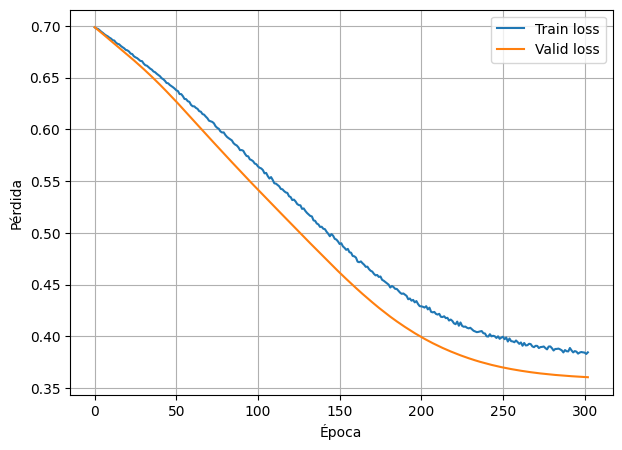

C:\Users\sevas\AppData\Local\Temp\ipykernel_22372\2633240813.py:301: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load("best_model_test.pt"

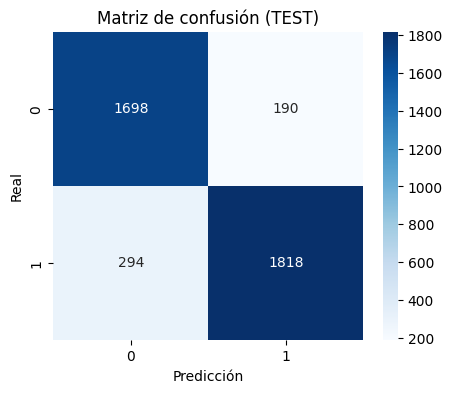

Accuracy: 0.879

              precision    recall  f1-score   support

           0     0.8524    0.8994    0.8753      1888
           1     0.9054    0.8608    0.8825      2112

    accuracy                         0.8790      4000
   macro avg     0.8789    0.8801    0.8789      4000
weighted avg     0.8804    0.8790    0.8791      4000



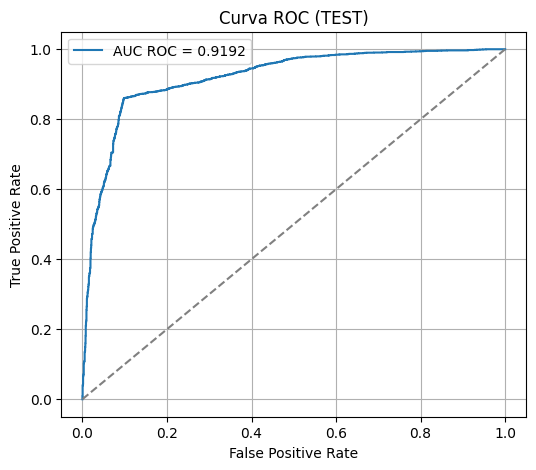

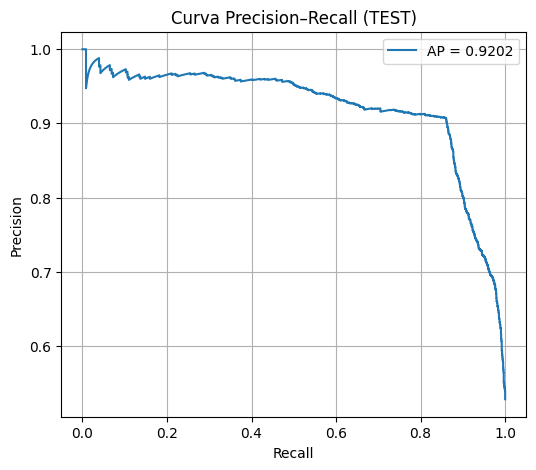

Nuevos pacientes: 5000
Predichos clase 1: 2517
Predichos clase 0: 2483
Probabilidad media clase 1: 0.54557854


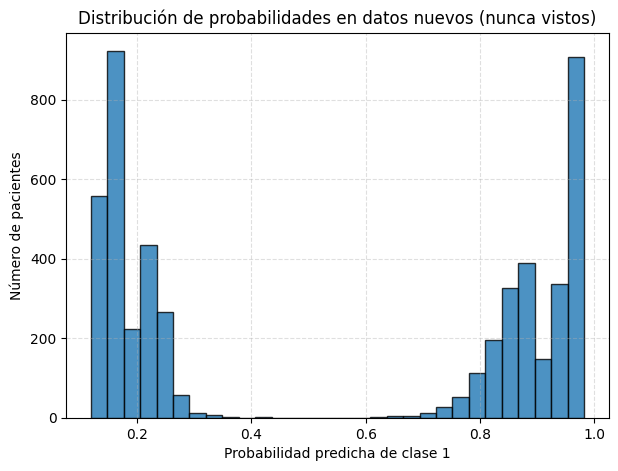

Archivo 'onc_fresh_con_predicciones.csv' guardado.


In [12]:
# ============================================================
# 0. IMPORTS Y DISPOSITIVO
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, accuracy_score,
    precision_recall_curve, average_precision_score
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# ============================================================
# 1. SEPARAR TRAIN / VALID / TEST A PARTIR DE X_num, X_cat, y
# ============================================================

# Unimos numéricas + categóricas
X_full = pd.concat([X_num, X_cat], axis=1)

num_cols = X_num.columns.tolist()
cat_cols = X_cat.columns.tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes ->",
      "Train:", X_train.shape,
      "Valid:", X_valid.shape,
      "Test:",  X_test.shape)

# ============================================================
# 2. IMPUTACIÓN DE NUMÉRICAS + COLUMNAS _missing
#    (SE AJUSTA SOLO CON TRAIN)
# ============================================================

# --- NUMÉRICAS TRAIN ---
X_train_num = X_train[num_cols].copy()
X_valid_num = X_valid[num_cols].copy()
X_test_num  = X_test[num_cols].copy()

# Medianas calculadas SOLO en train
num_medians = X_train_num.median()

# Añadimos columnas *_missing + rellenamos con la mediana
for col in num_cols:
    # columnas missing
    X_train_num[col + "_missing"] = X_train_num[col].isna().astype(int)
    X_valid_num[col + "_missing"] = X_valid_num[col].isna().astype(int)
    X_test_num[col  + "_missing"] = X_test_num[col].isna().astype(int)

    # rellenar NaNs con mediana de TRAIN
    X_train_num[col] = X_train_num[col].fillna(num_medians[col])
    X_valid_num[col] = X_valid_num[col].fillna(num_medians[col])
    X_test_num[col]  = X_test_num[col].fillna(num_medians[col])

# Nueva lista de columnas numéricas (incluye *_missing)
num_cols_extended = X_train_num.columns.tolist()

# ============================================================
# 3. CATEGÓRICAS: IMPUTACIÓN "MISSING" + LABEL ENCODER
#    (SE AJUSTA SOLO CON TRAIN)
# ============================================================

X_train_cat = X_train[cat_cols].copy()
X_valid_cat = X_valid[cat_cols].copy()
X_test_cat  = X_test[cat_cols].copy()

X_train_cat = X_train_cat.fillna("MISSING")
X_valid_cat = X_valid_cat.fillna("MISSING")
X_test_cat  = X_test_cat.fillna("MISSING")

label_encoders = {}

for col in cat_cols:
    enc = LabelEncoder()
    X_train_cat[col] = enc.fit_transform(X_train_cat[col].astype(str))

    # Para valid/test, sustituimos categorías desconocidas por "MISSING"
    known = set(enc.classes_)
    X_valid_cat[col] = (
        X_valid_cat[col]
        .astype(str)
        .where(X_valid_cat[col].astype(str).isin(known), other="MISSING")
    )
    X_test_cat[col] = (
        X_test_cat[col]
        .astype(str)
        .where(X_test_cat[col].astype(str).isin(known), other="MISSING")
    )

    X_valid_cat[col] = enc.transform(X_valid_cat[col].astype(str))
    X_test_cat[col]  = enc.transform(X_test_cat[col].astype(str))

    label_encoders[col] = enc

# ============================================================
# 4. ESCALADO DE NUMÉRICAS (SOLO LAS NO *_missing)
# ============================================================

# columnas que son valores numéricos reales (sin los *_missing)
original_num_cols = num_cols  # las iniciales
missing_flag_cols = [c for c in num_cols_extended if c.endswith("_missing")]

scaler = StandardScaler()
scaler.fit(X_train_num[original_num_cols].values.astype("float32"))

X_train_num_scaled_values = scaler.transform(X_train_num[original_num_cols].values.astype("float32"))
X_valid_num_scaled_values = scaler.transform(X_valid_num[original_num_cols].values.astype("float32"))
X_test_num_scaled_values  = scaler.transform(X_test_num[original_num_cols].values.astype("float32"))

# reconstruimos DataFrames numéricos escalados + flags
X_train_num_scaled = pd.DataFrame(
    X_train_num_scaled_values,
    columns=original_num_cols,
    index=X_train_num.index
)
X_valid_num_scaled = pd.DataFrame(
    X_valid_num_scaled_values,
    columns=original_num_cols,
    index=X_valid_num.index
)
X_test_num_scaled = pd.DataFrame(
    X_test_num_scaled_values,
    columns=original_num_cols,
    index=X_test_num.index
)

# añadimos flags *_missing (no se escalan)
for col in missing_flag_cols:
    X_train_num_scaled[col] = X_train_num[col].values
    X_valid_num_scaled[col] = X_valid_num[col].values
    X_test_num_scaled[col]  = X_test_num[col].values

# ============================================================
# 5. CONSTRUIR MATRICES FINALES DE FEATURES
# ============================================================

X_train_all = np.hstack([
    X_train_num_scaled.values.astype("float32"),
    X_train_cat.values.astype("float32")
])

X_valid_all = np.hstack([
    X_valid_num_scaled.values.astype("float32"),
    X_valid_cat.values.astype("float32")
])

X_test_all = np.hstack([
    X_test_num_scaled.values.astype("float32"),
    X_test_cat.values.astype("float32")
])

print("Feature dims ->", X_train_all.shape[1], "features totales")

# ============================================================
# 6. TENSORES Y DATALOADERS
# ============================================================

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(np.array(y_train)).long()

X_valid_tensor = torch.from_numpy(X_valid_all).float()
y_valid_tensor = torch.from_numpy(np.array(y_valid)).long()

X_test_tensor = torch.from_numpy(X_test_all).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

# ============================================================
# 7. DEFINIR MODELO (CON DROPOUT) + OPTIMIZADOR
# ============================================================

n_features = X_train_all.shape[1]

model_test = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 2)   # 2 clases
)

model_test = model_test.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_test.parameters(), lr=1e-6, weight_decay=1e-4)

# ============================================================
# 8. FUNCIONES DE TRAIN / EVAL
# ============================================================

def train_one_epoch():
    model_test.train()
    running_loss = 0.0
    for batchx, batchy in train_loader:
        batchx = batchx.to(device)
        batchy = batchy.to(device)

        optimizer.zero_grad()
        outputs = model_test(batchx)
        loss = criterion(outputs, batchy)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


def eval_one_epoch(loader):
    model_test.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batchx, batchy in loader:
            batchx = batchx.to(device)
            batchy = batchy.to(device)

            outputs = model_test(batchx)
            loss = criterion(outputs, batchy)
            running_loss += loss.item()
    return running_loss / len(loader)

# ============================================================
# 9. ENTRENAMIENTO CON EARLY STOPPING
# ============================================================

num_epochs = 2000
history_train = []
history_valid = []

best_valid_loss = float("inf")
patience = 10
no_improve_epochs = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch()
    valid_loss = eval_one_epoch(valid_loader)

    history_train.append(train_loss)
    history_valid.append(valid_loss)

    if valid_loss < best_valid_loss - 1e-3:
        best_valid_loss = valid_loss
        no_improve_epochs = 0
        torch.save(model_test.state_dict(), "best_model_test.pt")
        print(f"[Época {epoch:3d}] Nuevo mejor modelo guardado. valid_loss = {valid_loss:.4f}")
    else:
        no_improve_epochs += 1
        print(f"[Época {epoch:3d}] Sin mejora ({no_improve_epochs}/{patience})")

    print(f"           train_loss = {train_loss:.4f} | valid_loss = {valid_loss:.4f}")

    if no_improve_epochs >= patience:
        print("\n⛔ Early stopping activado.")
        break

# Curvas de pérdida
plt.figure(figsize=(7,5))
plt.plot(history_train, label="Train loss")
plt.plot(history_valid, label="Valid loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 10. EVALUACIÓN EN TEST (MATRIZ, ROC, PR)
# ============================================================

# Cargar mejor modelo
model_test.load_state_dict(torch.load("best_model_test.pt", map_location=device))
model_test.to(device)
model_test.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model_test(x_batch)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión (TEST)")
plt.show()

# --- Métricas ---
print("Accuracy:", accuracy_score(all_labels, all_preds))
print()
print(classification_report(all_labels, all_preds, digits=4))

# --- ROC y AUC ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_roc = roc_auc_score(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC ROC = {auc_roc:.4f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (TEST)")
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall ---
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap = average_precision_score(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall (TEST)")
plt.grid(True)
plt.legend()
plt.show()

# ============================================================
# 11. PREDICCIONES EN DATOS NUEVOS (limpio) + HISTOGRAMA
# ============================================================

limpio = pd.read_csv("onc_fresh_full_no_target.csv")
df_new = limpio.copy()

# --- NUMÉRICAS ---
df_new_num = df_new[num_cols].copy()

for col in num_cols:
    df_new_num[col + "_missing"] = df_new_num[col].isna().astype(int)
    df_new_num[col] = df_new_num[col].fillna(num_medians[col])

# Escalar columnas numéricas originales
new_num_scaled_vals = scaler.transform(df_new_num[original_num_cols].values.astype("float32"))
df_new_num_scaled = pd.DataFrame(
    new_num_scaled_vals,
    columns=original_num_cols,
    index=df_new_num.index
)

# añadir flags *_missing
for col in missing_flag_cols:
    df_new_num_scaled[col] = df_new_num[col].values

# --- CATEGÓRICAS ---
df_new_cat = df_new[cat_cols].copy().fillna("MISSING")

for col in cat_cols:
    enc = label_encoders[col]
    known = set(enc.classes_)
    df_new_cat[col] = (
        df_new_cat[col]
        .astype(str)
        .where(df_new_cat[col].astype(str).isin(known), other="MISSING")
    )
    df_new_cat[col] = enc.transform(df_new_cat[col].astype(str))

# --- UNIR NUM + CAT ---
X_new_all = np.hstack([
    df_new_num_scaled.values.astype("float32"),
    df_new_cat.values.astype("float32")
])

X_new_tensor = torch.from_numpy(X_new_all).float().to(device)

model_test.eval()
with torch.no_grad():
    logits_new = model_test(X_new_tensor)
    probs_new = F.softmax(logits_new, dim=1)[:, 1].cpu().numpy()
    preds_new = logits_new.argmax(dim=1).cpu().numpy()

print("Nuevos pacientes:", len(probs_new))
print("Predichos clase 1:", (preds_new == 1).sum())
print("Predichos clase 0:", (preds_new == 0).sum())
print("Probabilidad media clase 1:", probs_new.mean())

# Histograma de probabilidades
plt.figure(figsize=(7,5))
plt.hist(probs_new, bins=30, edgecolor="black", alpha=0.8)
plt.xlabel("Probabilidad predicha de clase 1")
plt.ylabel("Número de pacientes")
plt.title("Distribución de probabilidades en datos nuevos (nunca vistos)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Guardar CSV con predicciones (opcional)
salida = limpio.copy()
salida["prob_clase_1"] = probs_new
salida["pred_clase"] = preds_new
salida.to_csv("onc_fresh_con_predicciones.csv", index=False)
print("Archivo 'onc_fresh_con_predicciones.csv' guardado.")
